<a href="https://colab.research.google.com/github/Rush358/Fantasy-Premier-League/blob/main/FPL_Optimiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FPL Team Optimiser

A linear optimisation tool that selects the best starting 11 players for a Fantasy Premier League team, based on mean performance from the past 5 weeks, subject to budget and positional constraints. The outputs are visualised as:
*   Bar chart displaying each player's performance, benchmarked against the average player at that position.
*   Heatmap showing each player's next 5 fixtures, colour-coded for fixture difficulty.
---
## Notes
A description of how the tool functions, decisions taken/assumptions made, limitations and future developments can be found in the GitHub README.

All data used is taken from Vaastav Anand's GitHub Fantasy Premier League repository:
https://github.com/vaastav/Fantasy-Premier-League

# ETL

1.   Pulling in and cleansing raw FPL data (player performance, fixture information etc.).
2.   Merging separate tabular datasets together into a single dataframe with all necessary information.
3.   Filter dataframe to remove data unnecessary data.
4.   Aggregate filtered to summarise player performance over the last 5 gameweeks.

In [1]:
# Import and install necessary libraries
# ------------------------------------------------------------------------------
%%capture

# Import modules
import pandas as pd
import numpy as np
import urllib
#from urllib.error import HTTPError # Module to handle HTTP errors
import matplotlib.pyplot as plt

# Install PuLP
!pip install -U git+https://github.com/coin-or/pulp
from pulp import *

In [2]:
# Import FPL data into notebook
# ------------------------------------------------------------------------------

# Pull in CSVs from Git Hub repo
teams = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/teams.csv")
fixtures = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/fixtures.csv")
players_raw = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/players_raw.csv")
players_id = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/player_idlist.csv")

gw_data = [] # Initialise a list to pull in data for each gameweek

# Loop over every GW in the PL season
for i in range(1, 39):
  
  try: # Try to pull in GW information
    gw = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/gw" + str(i) + ".csv") 

  except urllib.error.HTTPError: # If GW doesn't exist yet, a HTTP error will be thrown - needs to be handled
    break # Break loop as GW (and future GWs) don't exist 

  else: # If current iteration GW exists then
    gw['gameweek'] = i # Add a column for this iteration's gameweek
    gw_data.append(gw) # Add GW dataframe to list of  

players = pd.concat(gw_data) # Concatenate list of gameweeks to a single dataframe

In [3]:
# Cleanse data by selecting wanted columns
# ------------------------------------------------------------------------------

teams_filt = teams[['id', 'strength', 'short_name']]
fixtures_filt = fixtures[['id', 'team_a','team_h']]
players_raw_filt = players_raw[['id','element_type']]
players_filt = players[['name','gameweek', 'value','fixture','opponent_team','total_points','minutes','transfers_balance','was_home']]
players_id['name'] = players_id['first_name'] + ' ' + players_id['second_name']

In [4]:
# Merge information onto players GW data
# ------------------------------------------------------------------------------

merged = players_filt.merge(fixtures_filt, how = 'left', left_on = 'fixture', right_on = 'id') # Fixture information
merged.drop(columns = ['id'], inplace = True)
merged = merged.merge(players_id, how = 'left', left_on = 'name', right_on = 'name') # Player ID information
merged = merged.merge(players_raw_filt, how = 'left', left_on = 'id', right_on = 'id') # Positional information
merged.rename(columns = {'id':'player_id'}, inplace = True)

In [5]:
# Merge team information onto players GW data
# ------------------------------------------------------------------------------

merged['team'] = np.where(merged['was_home'] == True, merged['team_h'], merged['team_a']) # Add player's team

merged = merged.merge(teams_filt, left_on = 'team', right_on = 'id' ) # Add player's team information
merged.rename(columns = {'strength':'team_diff', 'short_name':'team_short'}, inplace = True) # Rename columns before merging to team_filt again

merged = merged.merge(teams_filt, left_on = 'opponent_team', right_on = 'id')# Add opponent team's information
merged.rename(columns = {'strength':'opp_diff', 'short_name':'opp_short'}, inplace = True)

In [6]:
# Final cleaning of data before analysis
# ------------------------------------------------------------------------------

cleaned = merged.copy(deep = True) # Create a copy of the original before dropping columns
cleaned.drop(columns = ['id_x', 'id_y', 'first_name', 'second_name'], inplace = True) # Remove unnecessary columns

# Set column order to lay out dataframe logically
column_order = ['player_id', 'gameweek', 'name', 'element_type', 'value', 'fixture', 'team', 'team_short', 'team_diff', 'opponent_team', 'opp_short', 'opp_diff', 'was_home', 'team_a', 'team_h', 'total_points', 'minutes', 'transfers_balance']
cleaned = cleaned[column_order] 

In [7]:
# Check for null values in dataframe
# ------------------------------------------------------------------------------

cols_null = [] # List of columns with null value

for i in range(0, len(cleaned.columns)): # Loop through each column in dataframe
  
  check = cleaned.iloc[:, i].isnull().any() # Check if there any nulls in column

  if check == True:
    cols_null.append(i)

print('No null values found.') if len(cols_null) == 0 else print('Null values found.')

cleaned.head() # Show final cleaned data

No null values found.


,player_id,gameweek,name,element_type,value,fixture,team,team_short,team_diff,opponent_team,opp_short,opp_diff,was_home,team_a,team_h,total_points,minutes,transfers_balance
0,78,1,Aaron Connolly,4,55,7,3,BHA,3,5,CHE,4,True,5,3,1,45,0
1,60,1,Aaron Mooy,3,50,7,3,BHA,3,5,CHE,4,True,5,3,0,0,0
2,54,1,Adam Lallana,3,65,7,3,BHA,3,5,CHE,4,True,5,3,1,44,0
3,66,1,Adam Webster,2,45,7,3,BHA,3,5,CHE,4,True,5,3,1,90,0
4,80,1,Alexis Mac Allister,3,55,7,3,BHA,3,5,CHE,4,True,5,3,0,0,0


In [8]:
# Apply thresholds to filter data
# ------------------------------------------------------------------------------

# The most important threshold for prospective players to pass is minute threshold, as it is important that the team is made up of regular starters that maximise the opportunity to return points.
# The secondary threshold set is for points scored. There may be cases where high-level players come off the bench and still return, which needs to be factored into their performance.
# However it is likely to lead to underestimation of their true performance.

min_threshold = 60 # Generally the lower limit of what regular starters play
points_threshold = 4 # Four points implies some kind of return. 

In [10]:
# Extract last 5 GWs of data based on thresholds set
# ------------------------------------------------------------------------------

gw_current = cleaned['gameweek'].max()  
cleaned_last_5 = cleaned.loc[((cleaned['minutes'] >= min_threshold) | (cleaned['total_points'] >= points_threshold)) & (cleaned['gameweek'] > gw_current - 5)]

In [12]:
# Summarise players' performance in the last 5 GWs
# ------------------------------------------------------------------------------

# Final threshold is players having played at least 3 out of 5 GWs (needs to be applied post-aggregation)
gw_played_threshold = 3 

# Create a list for columns needed and aggregation types
column_agg = ['player_id', 'gameweek', 'name', 'element_type', 'value', 'team', 'team_short', 'team_diff', 'opp_diff', 'total_points', 'minutes', 'transfers_balance']
column_agg_type = ['max', ['max', 'count'], 'max', 'max', 'mean', 'max', 'max', 'mean', 'mean', ['mean', 'std'], 'mean', 'mean'] # Max aggregation on string columns just returns the string

agg_type = {column_agg[i]:column_agg_type[i] for i in range(len(column_agg))} # Create a dictionary to map column to appropriate aggregation

# Aggregate performance of last 5 GWs. Columns need to be renamed as a column hierarchy is created when doing mean and std on total_points.
last_5_agg = cleaned_last_5[column_agg].groupby(by = 'name', as_index = False).agg(agg_type)
last_5_agg.columns = ['player_id', 'gameweek', 'gameweeks_played','name', 'element_type', 'value', 'team', 'team_short', 'team_diff', 'opp_diff', 'mean_points', 'std_points', 'minutes', 'transfers_balance'] # Rename
last_5_agg = last_5_agg.loc[last_5_agg['gameweeks_played'] >= gw_played_threshold] # Apply gameweeks played in threshold

last_5_agg.dropna(axis = 0, subset = ['std_points'], inplace = True) # Remove any players which haven't played enough to calculate a stdev
last_5_agg.reset_index(drop = True, inplace = True) # Reset index to account for dropped values

In [14]:
# Update player value to reflect value in current GW
# ------------------------------------------------------------------------------

# Generate unique list of players
players_unique = last_5_agg['player_id'].unique()

# Loop through each player and set their value to the value of the most recent gameweek
for player in players_unique:

  # Find current value by finding most recent gameweek and extracting value column into an array that's accessed
  value_current = cleaned_last_5.loc[cleaned_last_5['player_id'] == player].nlargest(1, 'gameweek')['value'].values[0] 

  last_5_agg.loc[last_5_agg['player_id'] == player, 'value'] = value_current # Set value for considered player

last_5_agg.head()


,player_id,gameweek,gameweeks_played,name,element_type,value,team,team_short,team_diff,opp_diff,mean_points,std_points,minutes,transfers_balance
0,435,38,4,Aaron Cresswell,2,57.0,19,WHU,4,2.500000,4.000000,1.825742,90.000000,-31591.750000
1,483,38,5,Aaron Ramsdale,1,46.0,15,SHU,2,2.800000,5.400000,3.781534,90.000000,3998.600000
2,313,37,3,Aaron Wan-Bissaka,2,57.0,13,MUN,4,3.333333,3.333333,1.527525,90.000000,134631.333333
3,512,37,3,Abdoulaye Doucouré,3,51.0,7,EVE,3,2.666667,2.666667,0.577350,85.333333,163.000000
4,66,38,5,Adam Webster,2,43.0,3,BHA,3,3.800000,3.200000,2.588436,90.000000,721.600000


# Optimisation

1.   Setting up decision variables and objective function - maximise mean FPL points.
2.   Creating FPL constraints (spending money, team size, formation constraints).
3.   Solve optimisation problem and extract selected team into a dataframe.

In [15]:
# Set up optimisation problem
# ------------------------------------------------------------------------------

# Create the 'prob' variable to contain the problem data
prob1 = pulp.LpProblem('FPL_Optimisation', LpMaximize)

# Create decision variable for each player in data
decision_variables = [] # Initialise empty list

for row, player in last_5_agg.iterrows():
  dv_name = str('x' + str(row))
  dv = pulp.LpVariable(name = str(dv_name), lowBound = 0, upBound = 1, cat= 'Integer') # Generate binary decision variables
  decision_variables.append(dv) # Add to list

In [16]:
# Objective function (i.e. maximise points)
# ------------------------------------------------------------------------------

points_total = "" # Generate a string for the objective function

# Loop through each player's 5GW aggregated data, for their component of the objective function
for row, player in last_5_agg.iterrows():
  
  # Multiply the player's decision variable by their mean points to create their component of objective function
  points_comp = player['mean_points'] * decision_variables[row] # decision_variables row index aligns with last_5_agg row index

  points_total += points_comp # Append component to objective function

prob1 += points_total # Add objective function to LP problem

#print(points_total)

In [21]:
# Cost constraint function
# ------------------------------------------------------------------------------

price_lim = 83 * 10 # All prices are multiplied by 10 in imported data
price_cons = ""

# Loop through each player's 5GW aggregated data, for their component of the cost constraint
for row, player in last_5_agg.iterrows():
  
  # Multiply the player's decision variable by their mean points to create their component of objective function
  price_comp = player['value'] * decision_variables[row] # decision_variables row index aligns with last_5_agg row index

  price_cons += price_comp # Append to cost constraint

prob1 += (price_cons <= price_lim, 'Cost constraint') # Add cost constraint to LP problem

#print(price_cons)

In [22]:
# Team size constraint function
# ------------------------------------------------------------------------------

team_lim = 11 # Optimise to select starting 11
team_cons = ""

# Loop through each player's 5GW aggregated data
for row, player in last_5_agg.iterrows():
  
  # Each player is a component of the necessary starting 11
  team_comp = 1 * decision_variables[row] # decision_variables row index aligns with last_5_agg row index

  team_cons += team_comp # Append to team size constraint

prob1 += (team_cons == team_lim, 'Team size constraint') # Add team size constraint to LP problem

#print(team_cons)

In [23]:
# Positional constraints i.e. 1 goalkeeper, 4 defenders, 4 midfielders, 3 forwards
# ------------------------------------------------------------------------------

# FPL valid formations: 1 GK, at least 3 DEF, at least 1 FOR
gkp_lim = 1
def_min = 3
for_min = 1

gkp_cons = ""
def_cons = ""
for_cons = ""

# Loop through each player's 5GW aggregated data
for row, player in last_5_agg.iterrows():
  
  if player['element_type'] == 1: # GKP
    gkp_comp = 1 * decision_variables[row]
    gkp_cons += gkp_comp
  elif player['element_type'] == 2: # DEF
    def_comp = 1 * decision_variables[row]
    def_cons += def_comp
  elif player['element_type'] == 4: # FOR
    for_comp = 1 * decision_variables[row]
    for_cons += for_comp

# Add positional constraints
prob1 += (gkp_cons == gkp_lim, 'Goalkeeper constraint')
prob1 += (def_cons >= def_min, 'Defender constraint')
prob1 += (for_cons >= for_min, 'Forward constraint')

In [27]:
# Solve optimisation problem
# ------------------------------------------------------------------------------

# Set up solution and solve
prob1.writeLP('FPL_Team')
optimisation_result = prob1.solve()
print('Solution status:', LpStatus[prob1.status]) # Inform user on solution status, prob.status outputs integer value which is converted by LpStatus dict)

# Extract selected team from optimal solution
team_selected = []

for v in prob1.variables(): # Loop through each decision variable
  if v.varValue == 1: # If player has been selected add to list
    team_selected.append(int(v.name[1:])) # Strip first character 'x'

Solution status: Optimal


In [32]:
# Set up data structures for optimal team
# ------------------------------------------------------------------------------

team_optimised = last_5_agg[last_5_agg.index.isin(team_selected)].sort_values(by = ['element_type', 'mean_points'], ascending = True) # Produce a new dataframe
team_optimised.reset_index(drop = True, inplace = True)

# Select team captain (maximum point scorer)
team_optimised['multiplier'] = 1 # Initially set all 
team_optimised.loc[team_optimised['mean_points'].idxmax(), 'multiplier'] = 2 # Set highest scoring player as captain

# Set up series/lists for use in plotting results
team_optimised['name_plot'] = team_optimised['name'].replace(' ', '\n', regex = True) # Insert newline character \n for plotting
team_optimised['name_plot'] = team_optimised['name_plot'] + '\n' + team_optimised['team_short'] # Add player's team for plotting

# Find selected captain and add captain badge (C) to their name for the plot
captain_plot = team_optimised.loc[team_optimised['multiplier'] == 2, 'name_plot'] # Create 
team_optimised.loc[team_optimised['multiplier'] == 2, 'name_plot'] = captain_plot + '\n(C)'

# Set up a colour key depending on player position
element_type_list = [team_optimised['element_type'] == i for i in range(1,5)] # Set up a list of conditions for each player position
element_type_colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] # Set up outputs based on conditions i.e. the colour to assign
team_optimised['element_colour'] = np.select(element_type_list, element_type_colours, default = 'black') # Map positions to colour

team_optimised.head(11)

,player_id,gameweek,gameweeks_played,name,element_type,value,team,team_short,team_diff,opp_diff,mean_points,std_points,minutes,transfers_balance,multiplier,name_plot,element_colour
0,252,38,5,Alisson Ramses Becker,1,60.0,11,LIV,4,2.800000,7.200000,3.701351,90.000000,37807.400000,1,Alisson\nRamses\nBecker\nLIV,tab:blue
1,352,38,3,Jack Robinson,2,42.0,15,SHU,2,2.333333,6.333333,4.509250,90.000000,362.666667,1,Jack\nRobinson\nSHU,tab:orange
2,255,38,5,Andrew Robertson,2,73.0,11,LIV,4,2.800000,6.400000,5.594640,90.000000,46282.200000,1,Andrew\nRobertson\nLIV,tab:orange
3,259,38,5,Trent Alexander-Arnold,2,78.0,11,LIV,4,2.800000,6.600000,1.516575,90.000000,117320.400000,1,Trent\nAlexander-Arnold\nLIV,tab:orange
4,20,38,4,Joseph Willock,3,49.0,14,NEW,2,3.500000,8.000000,2.449490,85.000000,80078.500000,1,Joseph\nWillock\nNEW,tab:green
5,251,38,4,Sadio Mané,3,118.0,11,LIV,4,2.500000,9.500000,5.066228,90.000000,60718.750000,1,Sadio\nMané\nLIV,tab:green
6,287,36,3,Ferran Torres,3,69.0,12,MCI,5,3.000000,10.333333,9.073772,83.333333,3818.000000,1,Ferran\nTorres\nMCI,tab:green
7,543,38,4,Gareth Bale,3,92.0,17,TOT,4,3.000000,10.750000,8.180261,62.500000,23627.250000,1,Gareth\nBale\nTOT,tab:green
8,18,38,3,Nicolas Pépé,3,77.0,1,ARS,4,2.666667,13.333333,3.785939,90.000000,35522.666667,2,Nicolas\nPépé\nARS\n(C),tab:green
9,492,38,4,Rodrigo Moreno,4,57.0,10,LEE,3,2.750000,8.000000,2.943920,41.250000,18412.750000,1,Rodrigo\nMoreno\nLEE,tab:red


# Analysis

1.   Find performance of average FPL player to compare optimised team against.
2.   Visualise optimised team results over past 5 gameweeks, using average player performance as a benchmark.
3.   Retrieve the optimised team's upcoming fixtures and their relative difficulty.
4.   Visualise optimised team's upcoming fixtures and relative difficulty in a heatmap.

In [43]:
# Compare performance to average player of given position in last 5 GWs
# ------------------------------------------------------------------------------

# Create new dataframe to find the average performance over the last 5 GWs BY POSITION
cleaned_last_5_bl = cleaned_last_5.groupby(by = 'element_type', as_index = False).agg(agg_type)
cleaned_last_5_bl.columns = ['player_id', 'gameweek', 'gameweeks_played', 'name', 'element_type', 'value', 'team', 'team_short', 'team_diff', 'opp_diff', 'mean_points', 'std_points', 'minutes', 'transfers_balance']
cleaned_last_5_bl.drop(columns = ['player_id', 'gameweek', 'gameweeks_played', 'name', 'team', 'team_short', 'team_diff', 'opp_diff'], inplace = True) # Get rid of unnecessary columns
cleaned_last_5_bl.rename(columns = {'value':'value_bl', 'mean_points':'mean_points_bl', 'std_points':'std_points_bl', 'minutes':'minutes_bl'}, inplace = True) 

# Merge data of average performance by position onto optimised team
team_optimised = team_optimised.merge(cleaned_last_5_bl, how = 'left', left_on = 'element_type', right_on = 'element_type')

Starting 11 mean gameweek score: 109.
Starting 11 total budget: £78.1m (out of £83.0m).


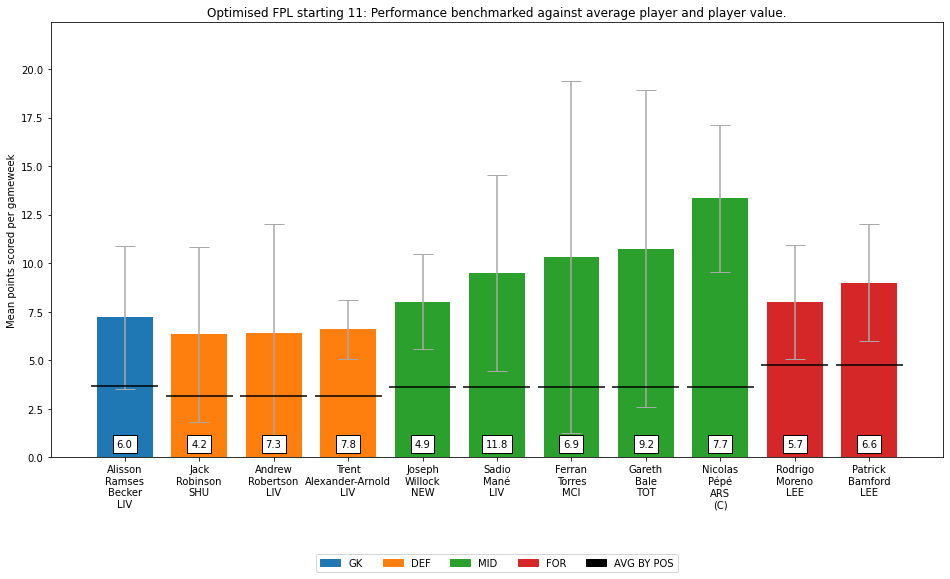

In [44]:
# View performance of optimal team's players
# ------------------------------------------------------------------------------

# Set up arrays to support plotting
x_lines = np.arange(0, 11, 1) # A comparison line needs to be set up for each player
x_lines_start = x_lines - 0.45 # Left bound of each comparison line
x_lines_end = x_lines + 0.45 # Right bound

# Plot results
fig, ax = plt.subplots(figsize = (16, 8))
ax.bar(x = team_optimised['name_plot'], height = team_optimised['mean_points'], yerr = team_optimised['std_points'],
        width = 0.75, capsize = 10,
        color = team_optimised['element_colour'], ecolor = 'darkgrey')

# Format chart
ax.set_title('Optimised FPL starting 11: Performance benchmarked against average player and player value.')
ax.set_ylabel('Mean points scored per gameweek')
ax.set_xticklabels(team_optimised['name_plot'], fontsize = 10, rotation = 0)
ax.set_ylim((0, team_optimised['mean_points'].max() + team_optimised['std_points'].max())) # Clip negative values
ax.hlines(y = team_optimised['mean_points_bl'], xmin = x_lines_start, xmax = x_lines_end) # Add comparison to each player i.e. how the average player with the same position performed

# Create custom legend
colours = {'GK':'tab:blue', 'DEF':'tab:orange', 'MID':'tab:green', 'FOR':'tab:red', 'AVG BY POS':'black'}         
labels = list(colours.keys()) # Legend labels
handles = [plt.Rectangle(xy = (0,0), width = 1, height = 1,
                         color = colours[label]) for label in labels] # Rectangular legend markers
ax.legend(handles, labels, loc='lower center', bbox_to_anchor = (0.5, -0.275), ncol = 5) # Create legend and set location

# Pair each player and their points value, then loop through
for x,y in zip(team_optimised['name_plot'], team_optimised['value'] / 10):

    label = '{:.1f}'.format(y) # Format points results to 2dp

    ax.annotate(label, # Data label (2dp)
                 (x, 0), # Position of label
                 textcoords = "offset points", # How label is positioned
                 xytext = (0, 10), # Distance from label to points (x,y)
                 ha = 'center', # Horizontal alignment
                 #va = 'bottom',
                 bbox = {'facecolor':'white'}
                 )

# Optimised team information    
total_score = round((team_optimised['mean_points'] * team_optimised['multiplier']).sum())
total_price = team_optimised['value'].sum() / 10 # Convert player value into millions

# Show user results
fig.show()
print('Starting 11 mean gameweek score: ' + str(total_score) + '.')
print('Starting 11 total budget: £' + str(total_price) + 'm (out of £83.0m).')

In [49]:
# Extract upcoming fixtures into dataframe
# ------------------------------------------------------------------------------

# Extract necessary information from fixtures and format as required
fixtures_upcoming = fixtures[['id', 'event', 'kickoff_time', 'finished', 'team_h', 'team_a', 'team_h_difficulty', 'team_a_difficulty']]
fixtures_upcoming = fixtures_upcoming.dropna(axis = 0, subset = ['event']) # Get rid of null fixtures
fixtures_upcoming.reset_index(drop = True, inplace = True)
fixtures_upcoming.rename(columns = {'event':'gameweek'}, inplace = True)
fixtures_upcoming = fixtures_upcoming.astype({'gameweek':int})
fixtures_upcoming['kickoff_time'] = pd.to_datetime(fixtures_upcoming['kickoff_time'])

# Filter data to return future gameweeks, which haven't been completed and sort them
fixtures_upcoming = fixtures_upcoming.loc[(fixtures_upcoming['gameweek'] > gw_current - 5) & (fixtures_upcoming['finished'] == True)].sort_values(by = 'kickoff_time', ascending = True)

In [50]:
# Extract the next 5 fixtures (and their difficulties) for each player from the optimal team
# ------------------------------------------------------------------------------

# Initialise arrays
fixtures_array = np.zeros((11, 5))
fixtures_array_short = np.zeros((11, 5), dtype = 'U3')
diff_array = np.zeros((11, 5))

# Loop through each player
for row, player in team_optimised.iterrows():
  
  player_team = player['team'] # Extract team
  
  # Create dataframe for player to find out information on their upcoming fixtures
  player_fixtures = fixtures_upcoming.loc[(fixtures_upcoming['team_h'] == player_team) | (fixtures_upcoming['team_a'] == player_team)] # Filter for given player's fixtures (home or away)
  player_fixtures = player_fixtures.nsmallest(n = 5, columns = 'kickoff_time') # Get next 5 upcoming games
  player_fixtures['opponent_team'] =  np.where(player_fixtures['team_h'] == player_team, player_fixtures['team_a'], player_fixtures['team_h']) # Determine the opponent team
  player_fixtures = player_fixtures.merge(teams_filt, how = 'left', left_on = 'opponent_team', right_on = 'id')

  # Extract fixtures information and write to array to be plotted in a heatmap
  player_fixtures_opp = player_fixtures['opponent_team'].to_numpy()
  player_fixtures_short = player_fixtures['short_name'].to_numpy()
  player_fixtures_opp_diff = player_fixtures['strength'].to_numpy()
  
  fixtures_array[row, :] = player_fixtures_opp # Insert information into initialised arrays
  fixtures_array_short[row, :] = player_fixtures_short
  diff_array[row, :] = player_fixtures_opp_diff

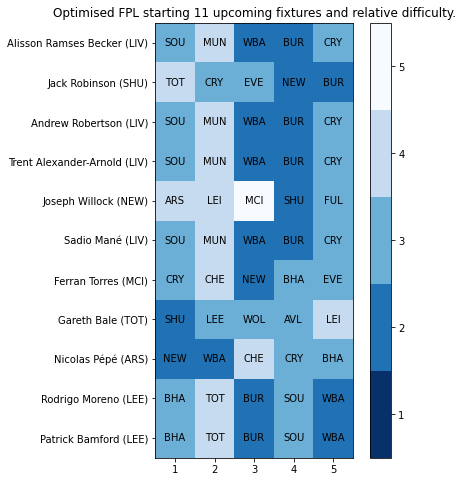

In [51]:
# Produce heatmap to show upcoming fixtures and difficulties
# ------------------------------------------------------------------------------

colourmap = plt.get_cmap('Blues_r', 5) # Set up colourmap with 5 increments (fixture difficulty measured from 1-5)
diff_scale = [1, 2, 3, 4, 5] # List used to represent the 1-5 fixture difficulty scale 
gw_upcoming = [1, 2, 3, 4, 5] # List for the next 5 games to be palyed

# Create heatmap plot and colourbar
fig, ax = plt.subplots(figsize = (6, 8))
im = ax.imshow(X = diff_array, cmap = colourmap, # Heatmap (fixture colours) determined by fixture difficulty from 1-5
               vmin = 0.5, vmax = 5.5) # Set colourbar bounds, 0.5 is required to position tick halfway between each increment 
cbar = plt.colorbar(im) # Create colourbar
cbar.set_ticks(diff_scale) # Position each tick
cbar.ax.set_yticklabels(diff_scale) # Label each tick with difficulty

# Format heatmap
ax.set_title('Optimised FPL starting 11 upcoming fixtures and relative difficulty.')
ax.set_xticks(np.arange(5)) # Insert xtick for each of the next 5 fixtures
ax.set_yticks(np.arange(11)) # Insert ytick for each of the team's 11 players
ax.set_xticklabels(gw_upcoming) # Label each game
ax.set_yticklabels(team_optimised['name'] + ' (' + team_optimised['team_short'] + ')') # Label each player

# Loop through each player in the team
for y in range(len(team_optimised['name'])):
    for x in range(len(gw_upcoming)): # Loop through each fixture
        text = ax.text(x, y, fixtures_array_short[y, x],
                       ha="center", va="center", color="black", size = 10)